This notebook aims to calculate the lightning NO2 production efficiencies.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import proplot as pplt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter

from shapely.prepared import prep
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
import shapely.vectorized

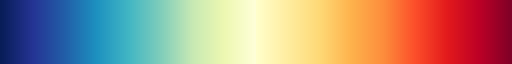

In [2]:
# create colormap
cmap = pplt.Colormap('YlGnBu_r', 'YlOrRd', ratios=(1, 1), name='tropomi_no2')
cmap

## Read gridded lightning NO2 production data

In [3]:
# output of `s5p_lnox_grid.py`
# lno2_grid = xr.open_dataset('../data/S5P_LNO2_grid.nc')['lno2'].sum(dim='swath', skipna=True)
lno2_grid = xr.open_dataset('../data/S5P_LNO2_grid.nc')['lno2_sum'].sum(dim='swath', skipna=True)
lightning_grid = xr.open_dataset('../data/S5P_LNO2_grid.nc')['lightning'].sum(dim='swath', skipna=True)
lightning_grid_500hpa = xr.open_dataset('../data/S5P_LNO2_grid.nc')['lightning_500hpa'].sum(dim='swath', skipna=True)

# corrected by detection efficiency and IC:CG ratio (~1)
lightning_grid *= 4
lightning_grid_500hpa *= 4

lno2_emiss_pixel = xr.open_dataset('../data/S5P_LNO2_grid.nc')['lno2_max'].max(dim=['longitude', 'latitude'])#.mean(dim='swath')
#lno2_emiss_pixel_std = xr.open_dataset('../data/S5P_LNO2_grid.nc')['lno2_max'].max(dim=['longitude', 'latitude']).std(dim='swath')

In [4]:
def plot_lno2_grid(lno2_grid, ax):
    lats, lons = np.meshgrid(lno2_grid['latitude'], lno2_grid['longitude'])

    m = ax.pcolormesh(lons, lats, lno2_grid.where(lno2_grid>0)/1e3, cmap=cmap, vmin=0, vmax=60, discrete=False, extend='max',
                      cmap_kw={'left': 0.05, 'right': 0.95})
    # m = ax.scatter(lons.ravel(), lats.ravel(), c=lno2_grid.values.ravel(), s=5, cmap=cmap, vmin=0, vmax=400, discrete=False, extend='max')

    ax.colorbar([m], ticks=20, loc='b', label=r'Lightning NO$_2$ ($\times$10$^3$ mol)')
    ax.format(title='')


def plot_lightning_grid(lightning_grid, ax):
    lats, lons = np.meshgrid(lightning_grid['latitude'], lightning_grid['longitude'])

    m = ax.pcolormesh(lons, lats, lightning_grid.where(lightning_grid>0)/1e3, cmap=cmap,  vmin=0.1, vmax=400, discrete=False, extend='max', cmap_kw={'left': 0.05, 'right': 0.95}, norm=LogNorm())
    # m = ax.pcolormesh(lons, lats, lightning_grid.where(lightning_grid>0)/1e3, cmap=cmap,  vmin=0.1, vmax=50, discrete=False, extend='max', cmap_kw={'left': 0.05, 'right': 0.95})
    # m = ax.scatter(lons.ravel(), lats.ravel(), c=lno2_grid.values.ravel(), s=5, cmap=cmap, vmin=0, vmax=400, discrete=False, extend='max')

    ax.colorbar([m], loc='b', label=r'Lightning strokes ($\times$10$^3$)')
    ax.format(title='')


def plot_pe(df, ax):
    s = ax.scatter(df['longitude'], df['latitude'], c=df['pe_lno2'], vmin=0, vmax=100, s=10, extend='max', cmap=cmap,
                   cmap_kw={'left': 0.05, 'right': 0.95})
    ax.colorbar([s], loc='b', label='Lightning NO$_2$ production efficiency \n (mol per stroke)')
    ax.format(title='')

/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_20776/3902122261.py:15: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.stock_img()
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_20776/3902122261.py:16: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.text(-42, 77, '80$^{\circ}$ N', rotation=-45, transform=ccrs.PlateCarree())


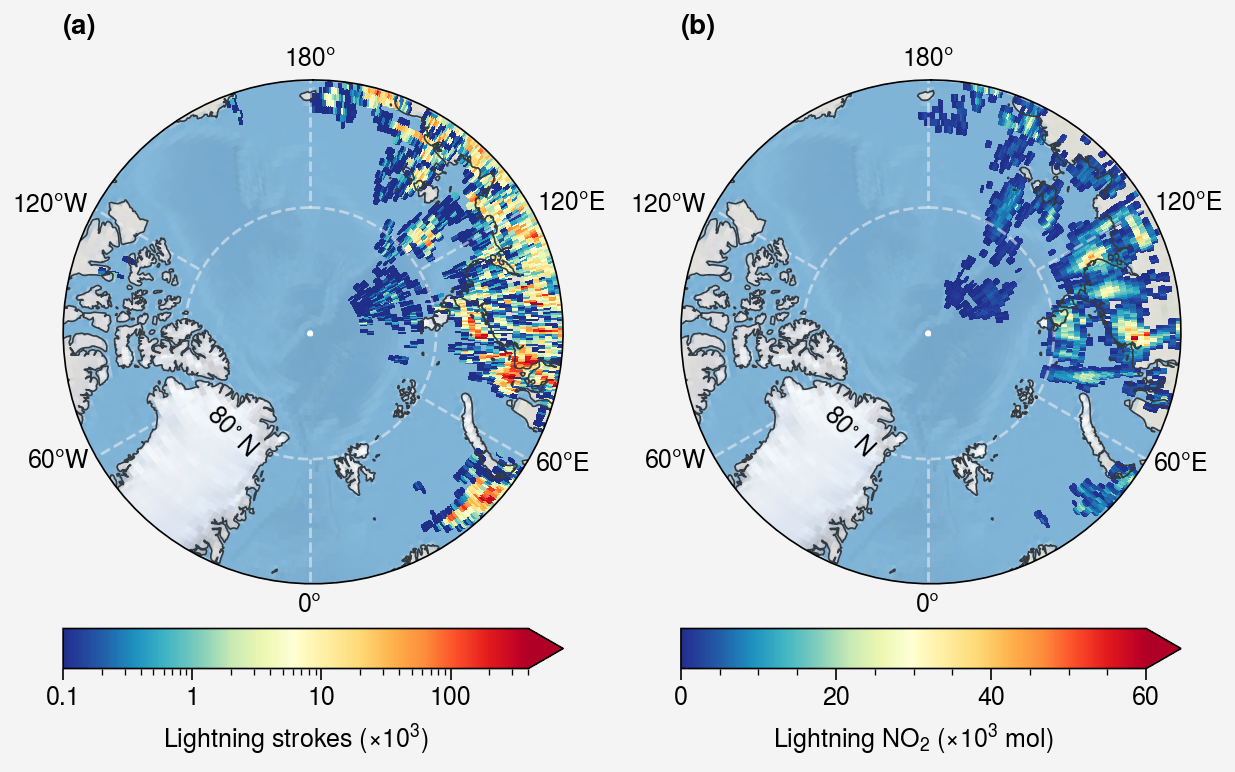

In [5]:
fig, axs = pplt.subplots(proj='npstere', ncols=2)

axs.format(reso='med', abc='(a)',
        latlines=10, gridcolor='gray2', gridlinewidth=1, gridalpha=0.6, gridlinestyle='--',
        # latinline=True, gridlabelcolor='w',
        lonlabels='lrbt', boundinglat=70,
        # landcolor='gray5', land=True,
        coast=True, coastcolor='gray8',
        )

plot_lightning_grid(lightning_grid, axs[0])
plot_lno2_grid(lno2_grid, axs[1])


axs.stock_img()
axs.text(-42, 77, '80$^{\circ}$ N', rotation=-45, transform=ccrs.PlateCarree())

fig.savefig('../figures/lno2_production.png')

Summed data for selected cases per 0.5◦ × 0.5◦ grid. (a) GLD360 lightning stroke, (b) Lightning NO2 retrieved by TROPOMI observations.

## Relationship between production efficiency and stroke rate

### Read lightning no2 production data

In [6]:
def filter_case(df):
    df_lno2 = df[(df['pe_lno2']>0)&(df['pe_lno2geo']>0)&(df['pe_lno2vis'])>0]

    return df_lno2

df_lno2 = pd.read_csv('../data/S5P_LNO2_production.csv')
df_lno2 = filter_case(df_lno2)

# corrected stroke considering the detection efficiency
df_lno2['nlightning'] *= 4
df_lno2['pe_lno2'] /= 4

df_lno2['time'] = pd.to_datetime(df_lno2['time'])
df_lno2['lfr'] = df_lno2['nlightning']/df_lno2['area']

### Add the region info

In [7]:


def get_geom(name, category='physical', resolution='50m'):
    # https://stackoverflow.com/questions/47894513/
    #    checking-if-a-geocoordinate-point-is-land-or-ocean-with-cartopy
    shp_fname = shpreader.natural_earth(name=name,
                                        resolution=resolution,
                                        category=category
                                       )
    if name == 'coastline':
        # https://shapely.readthedocs.io/en/stable/manual.html#object.buffer
        geom = unary_union(list(shpreader.Reader(shp_fname).geometries())).buffer(0.5)
    else:
        geom = unary_union(list(shpreader.Reader(shp_fname).geometries()))

    return prep(geom)

land_geom = get_geom('land')
coast_geom = get_geom('coastline')
ocean_geom = get_geom('ocean')

cond_coast = shapely.vectorized.contains(coast_geom, df_lno2['longitude'], df_lno2['latitude'])
cond_land = shapely.vectorized.contains(land_geom, df_lno2['longitude'], df_lno2['latitude'])
cond_ocean = shapely.vectorized.contains(ocean_geom, df_lno2['longitude'], df_lno2['latitude'])

region = np.argmax(np.vstack((cond_coast, cond_land, cond_ocean))==1, axis=0)
df_lno2['region'] = region

In [8]:
# 0: 'coast', 1: 'land', 2: 'ocean'
df_lno2['pe_lno2'][df_lno2['region']==0].quantile(0.25), df_lno2['pe_lno2'][df_lno2['region']==1].quantile(0.25), df_lno2['pe_lno2'][df_lno2['region']==2].quantile(0.25)

(1.2971224932612955, 0.3459014741975599, 1.1579806692479524)

In [9]:
df_lno2['pe_lno2'][df_lno2['region']==0].quantile(0.75), df_lno2['pe_lno2'][df_lno2['region']==1].quantile(0.75), df_lno2['pe_lno2'][df_lno2['region']==2].quantile(0.75)

(33.76896700574154, 4.25728295000495, 28.418800411689716)

### Relationship

In [10]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

# perform the fit
from scipy.optimize import curve_fit

# lfr_bins = np.arange(1e-9, 8e-8, 5e-9)
lfr_bins = np.arange(0, 5e-7, 5e-9)#2e-9)
lfr_mid = pd.Series(lfr_bins).rolling(2).mean()[1:].values
pe_bin = df_lno2.groupby(pd.cut(df_lno2['lfr'], bins=lfr_bins))['pe_lno2'].mean()
pe_std = df_lno2.groupby(pd.cut(df_lno2['lfr'], bins=lfr_bins))['pe_lno2'].std()

valid_mask = np.logical_not(np.isnan(pe_bin))
xs = lfr_mid[valid_mask]
ys = pe_bin[valid_mask]
ystd = pe_std[valid_mask]

p0 = (20, .1, 50) # start with values near those we expect
params, cv = curve_fit(monoExp, xs, ys, p0)
m, t, b = params

# determine quality of the fit
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# ax.legend(l, loc='ur')
base, power = f'{-t:.2e}'.split('e')
print(f'y={m.round(2)}e$^{{{base}*10^{{{power}}}x}}$+{b.round(2)}')


R² = 0.968191337259564
y=151.8e$^{-9.85*10^{+07}x}$+4.72


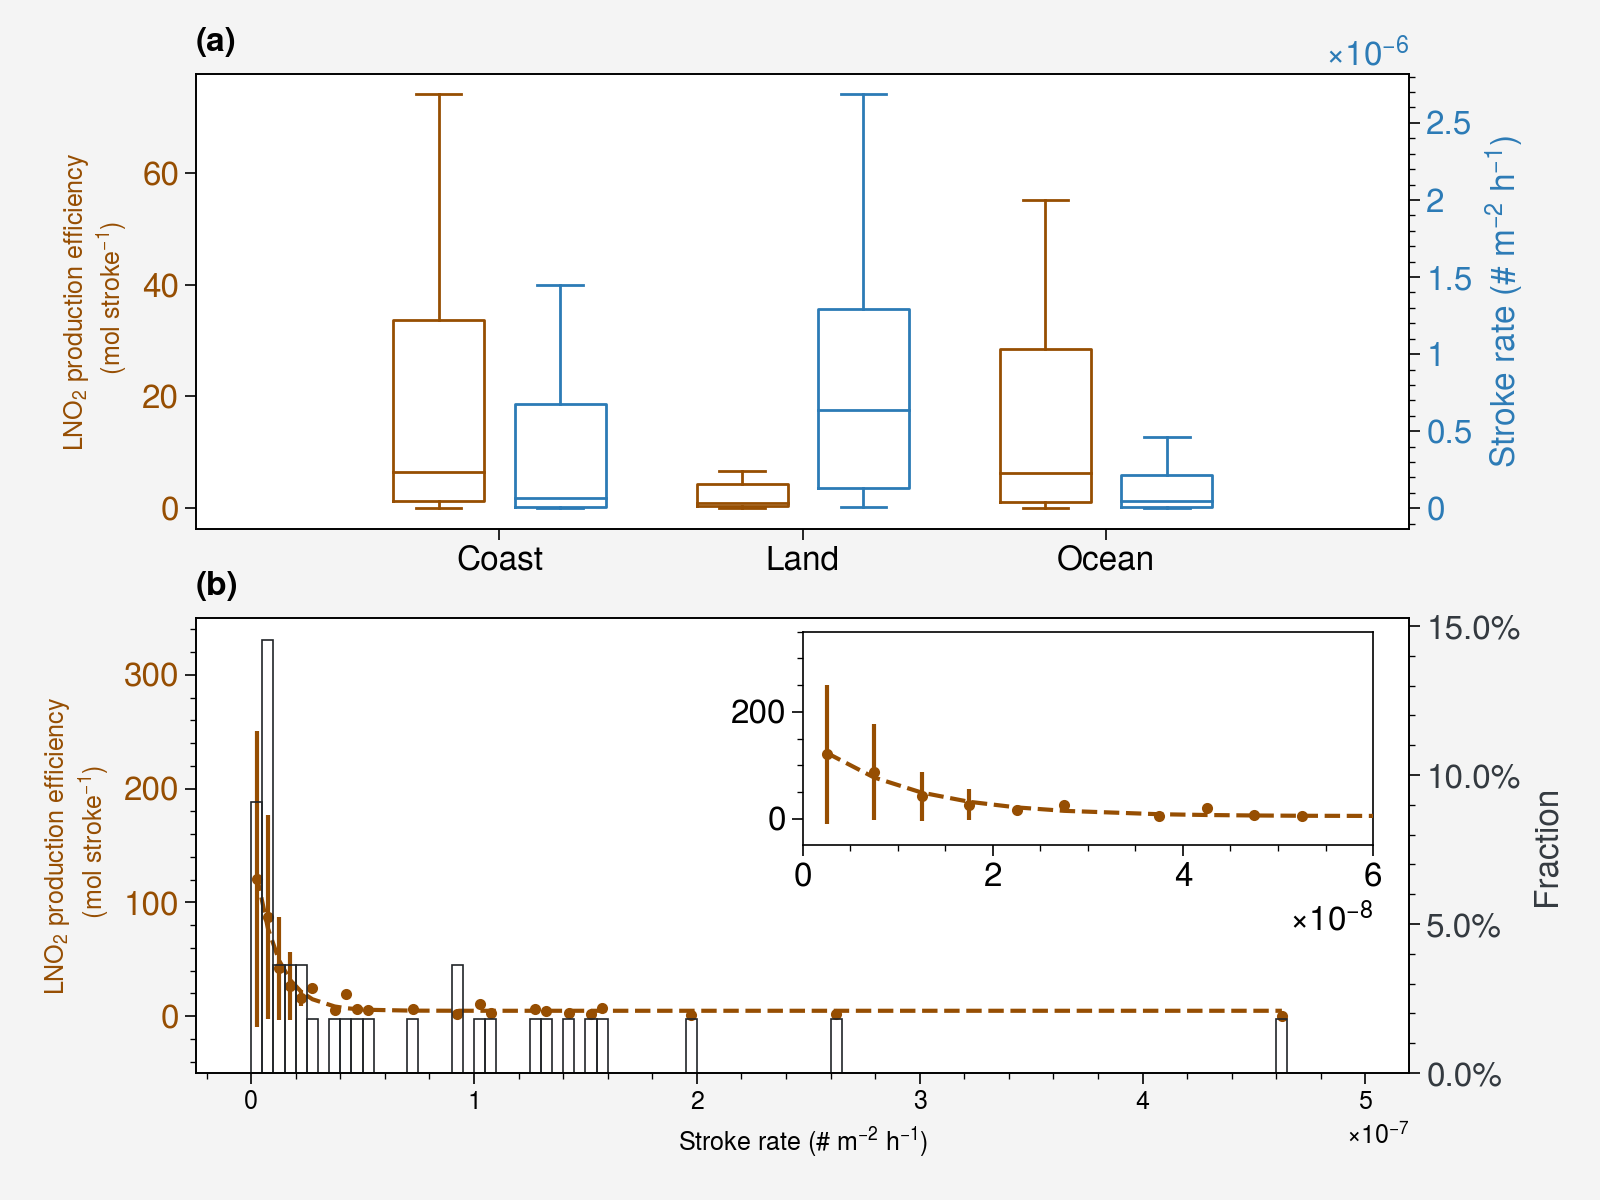

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

plt.rcParams.update({'font.size': 12, 'font.family':'sans-serif'})

pe_grp = list(df_lno2.groupby('region')['pe_lno2'].agg(list))
lfr_grp = list(df_lno2.groupby('region')['lfr'].agg(list))

bpl = ax1.boxplot(pe_grp, positions=np.array(range(len(pe_grp)))*2.0-0.4, sym='', widths=0.6)

ax3 = ax1.twinx()
bpr = ax3.boxplot(lfr_grp, positions=np.array(range(len(lfr_grp)))*2.0+0.4, sym='', widths=0.6)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

set_box_color(bpl, 'warm brown')
set_box_color(bpr, '#2C7BB6')

ticks = ['Coast', 'Land', 'Ocean']
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
ax1.set_xlim(-2, len(ticks)*2)

# # ------- plot LNO2 production ---------
ax4 = ax2.twinx()
mask = df_lno2['nlightning']>100
df_lno2['lfr'][mask].plot.hist(bins=lfr_bins,
                                     weights=np.ones(len(df_lno2[mask])) / len(df_lno2[mask]),
                                     fc='none', edgecolor='gray9', ax=ax4, zorder=1)
ax4.yaxis.set_major_formatter(PercentFormatter(1))

ax2.plot(xs, ys, '.', c='warm brown', zorder=100)
ax2.errorbar(xs, ys, ystd, fmt='none', c='warm brown', capsize=0, zorder=100)
ax2.plot(xs, monoExp(xs, m, t, b), '--', c='warm brown', zorder=100)
ax2.set_ylim([-50, 350])


ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax4.grid(False)

ax1.set_ylabel('LNO$_2$ production efficiency \n (mol stroke$^{-1}$)', color='warm brown')
ax3.set_ylabel('Stroke rate (# m$^{-2}$ h$^{-1}$)', color='#2C7BB6')
ax2.set_xlabel('Stroke rate (# m$^{-2}$ h$^{-1}$)')
ax2.set_ylabel('LNO$_2$ production efficiency \n (mol stroke$^{-1}$)', color='warm brown')


ax4.set_ylabel('Fraction', color='gray8')

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelcolor='warm brown', labelsize=12)
ax2.tick_params(axis='y', labelcolor='warm brown', labelsize=12)
ax3.tick_params(axis='y', labelcolor='#2C7BB6', labelsize=12)
ax4.tick_params(axis='y', labelcolor='gray8', labelsize=12)

ax1.minorticks_off()

plt.tight_layout()

ax1.text(0, 1.05, '(a)', transform=ax1.transAxes, size=12, weight='bold')
ax2.text(0, 1.05, '(b)', transform=ax2.transAxes, size=12, weight='bold')

axins = ax2.inset_axes([0.5, 0.5, 0.47, 0.47])
axins.plot(xs, ys, '.', c='warm brown', zorder=100)
axins.errorbar(xs, ys, ystd, fmt='none', c='warm brown', capsize=0, zorder=100)
axins.plot(xs, monoExp(xs, m, t, b), '--', c='warm brown', zorder=100)
axins.set_ylim([-50, 350])
axins.set_xlim([0, 6e-8])
axins.grid(False)

fig.savefig('../figures/pe_rate.pdf')